In [21]:


%matplotlib inline

import geopandas as gpd



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression

In [2]:
# Load US Census Tracts
us_tracts = pd.read_csv('./data/us_tracts.csv', index_col=0)
us_tracts.head()

tract        lat        lon
0  1005950300  31.790893 -85.567051
1  1005950900  31.846722 -85.146233
2  1005950800  31.920693 -85.176032
3  1005950700  31.944085 -85.262084
4  1005950600  31.878353 -85.272921

In [3]:
# Merge with US Census Data
census = pd.read_csv("data/census.csv", index_col = 0)
census.head()

CensusTract    State   County  Urban  POP2010  OHU2010  GroupQuartersFlag  \
0   1001020100  Alabama  Autauga      1     1912      693                  0   
1   1001020200  Alabama  Autauga      1     2170      743                  0   
2   1001020300  Alabama  Autauga      1     3373     1256                  0   
3   1001020400  Alabama  Autauga      1     4386     1722                  0   
4   1001020500  Alabama  Autauga      1    10766     4082                  0   

   NUMGQTRS  PCTGQTRS  LILATracts_1And10  ...  TractBlack  TractAsian  \
0         0  0.000000                  0  ...         217          14   
1       181  0.083410                  0  ...        1217           5   
2         0  0.000000                  0  ...         647          17   
3         0  0.000000                  0  ...         193          18   
4       181  0.016812                  0  ...        1437         296   

   TractNHOPI  TractAIAN  TractOMultir  TractHispanic  TractHUNV  TractSNAP  \
0           0         14            45             44         26        112   
1           0          5            55             75         87        202   
2           5         11           117             87        108        120   
3           4         11            74             85         19         82   
4           9         48           310            355        198        488   

   la_flag  fd_flag  
0        1        0  
1        1        0  
2        1        0  
3        1        0  
4        1        0  

[5 rows x 149 columns]

In [4]:
merge = census.merge(us_tracts, left_on='CensusTract', right_on='tract')

In [5]:
merge.shape

(72864, 152)

In [6]:
# Separate Alaska and Hawaii for easier visualization
alaska = merge[merge['State'] == "Alaska"]
hawaii = merge[merge['State'] == 'Hawaii']
mainland = merge[(merge.State != "Hawaii") & (merge.State != "Alaska")]

In [7]:
mainland.shape

(72365, 152)

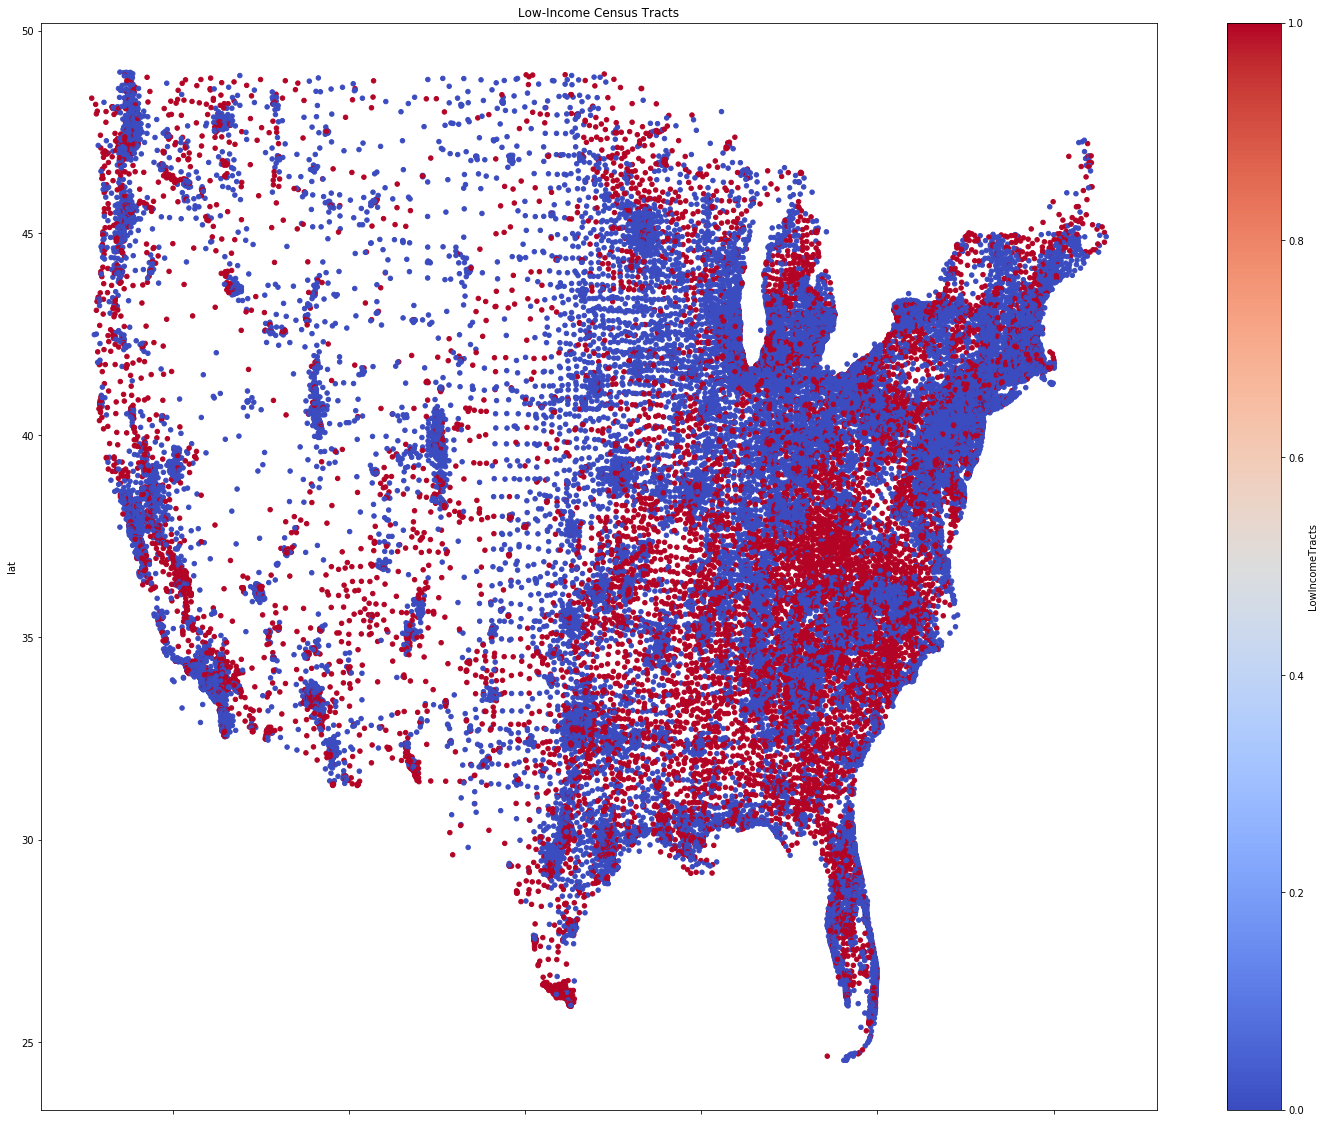

In [8]:
mainland.plot(kind = 'scatter' , x= 'lon', y= 'lat', c = 'LowIncomeTracts',
              cmap = 'coolwarm',
              title = 'Low-Income Census Tracts',
              figsize = (25,20));

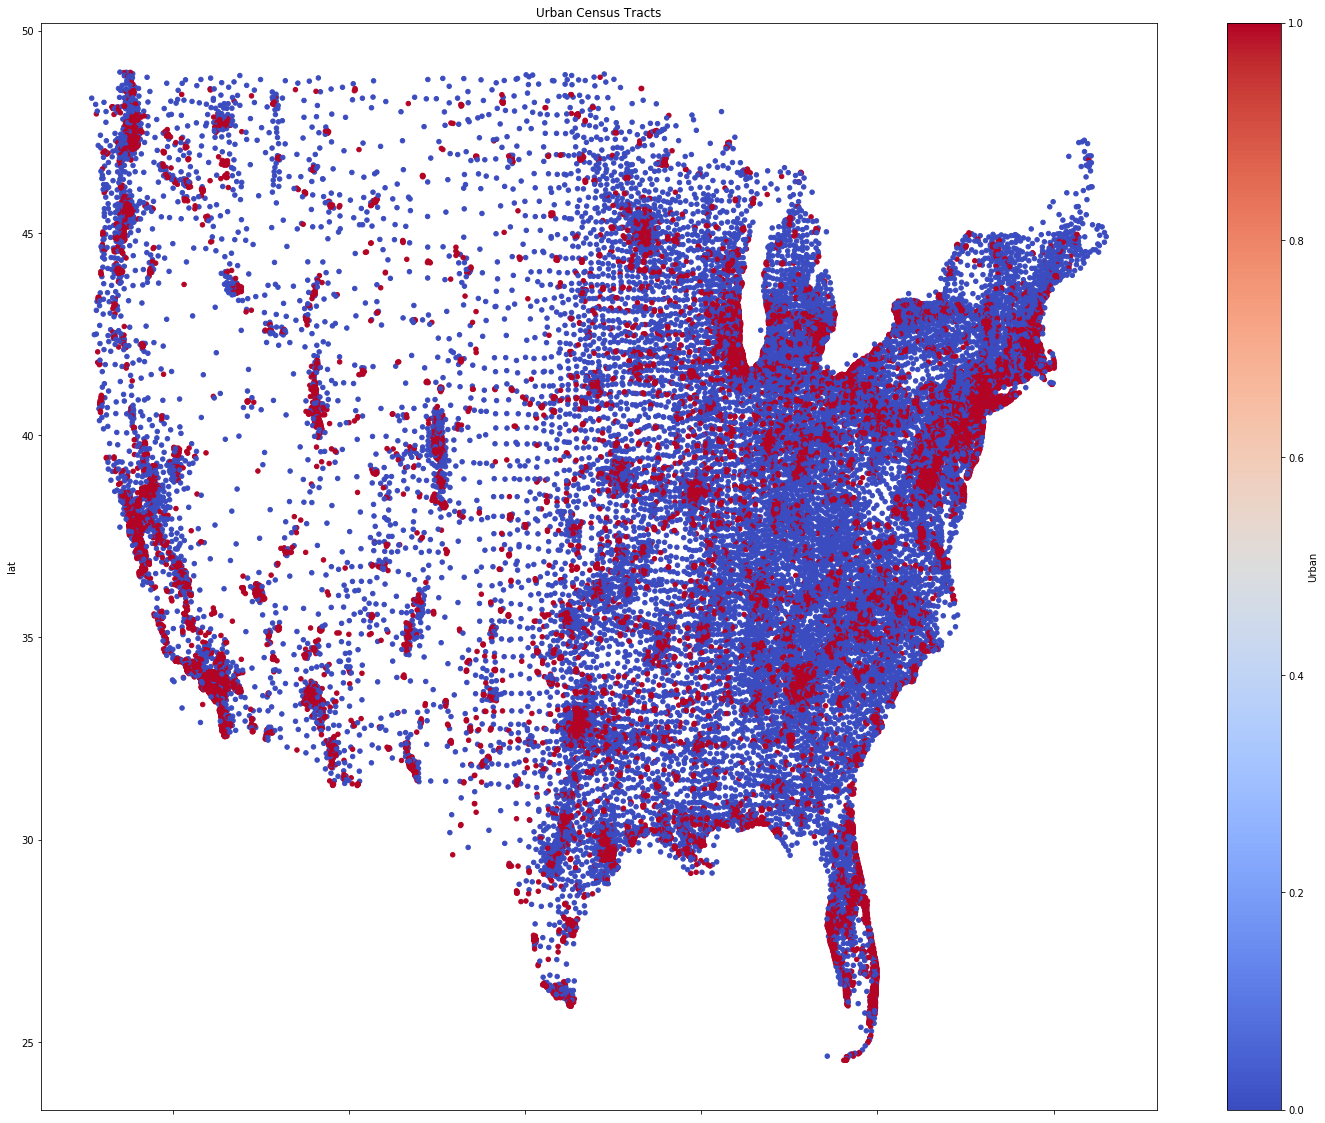

In [230]:
mainland.plot(kind = 'scatter' , x= 'lon', y= 'lat', c = 'Urban',
              cmap = 'coolwarm',
              title = 'Urban Census Tracts',
              figsize = (25,20));

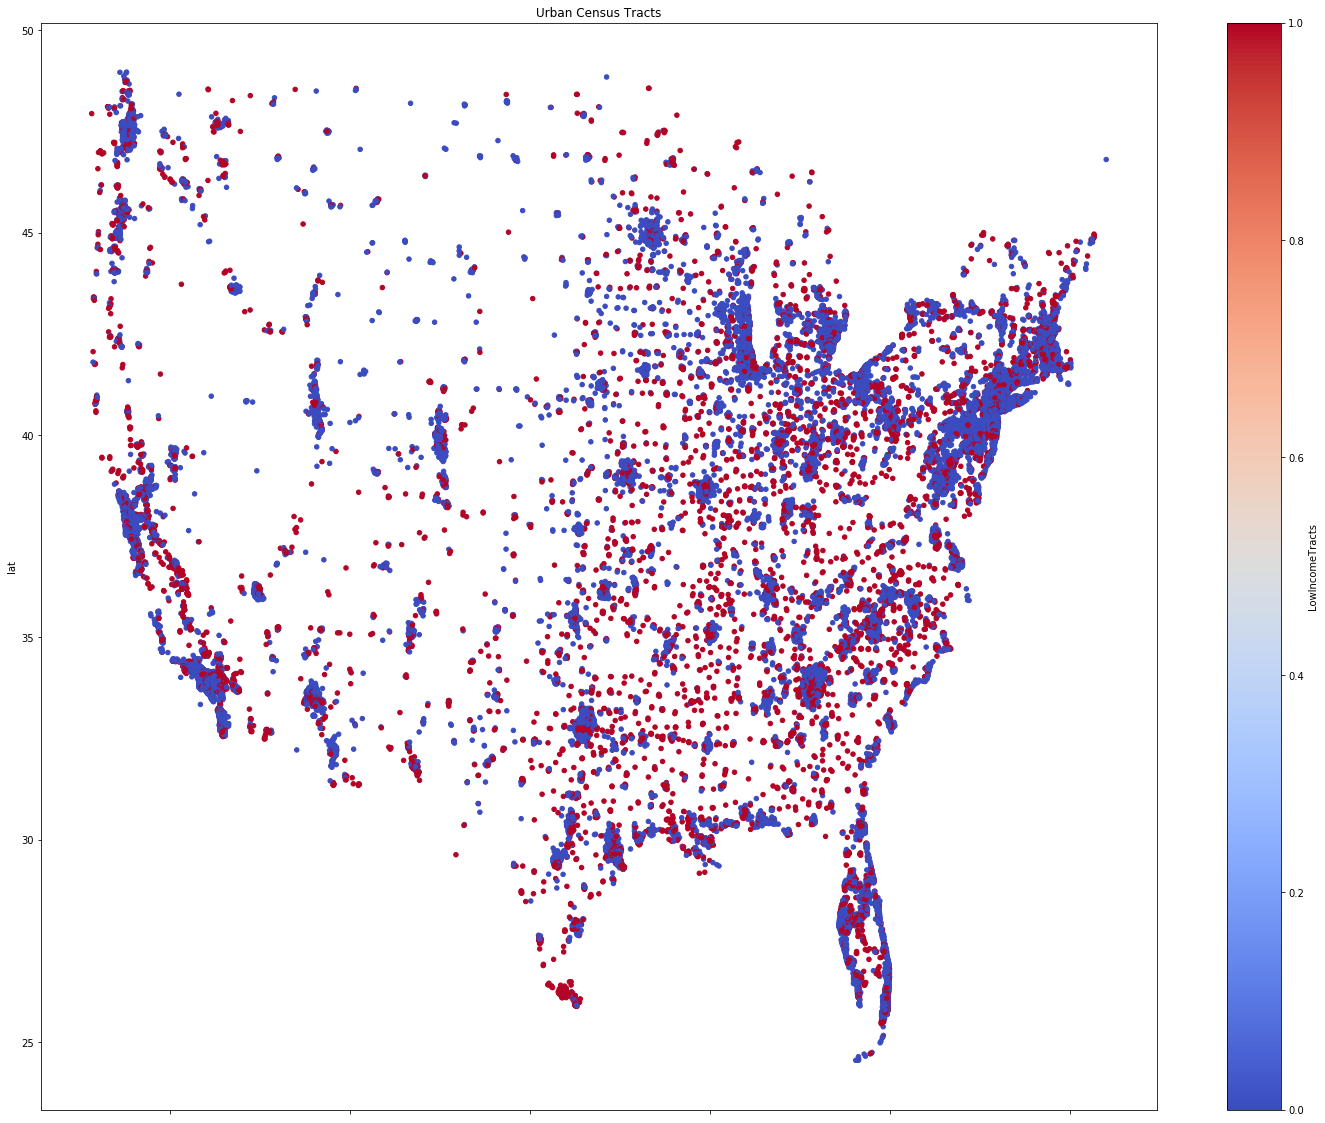

In [233]:
mainland[mainland['Urban'] == 1].plot(kind = 'scatter' , x= 'lon', y= 'lat', c = 'LowIncomeTracts',
              cmap = 'coolwarm',
              title = 'Urban Census Tracts',
              figsize = (25,20));

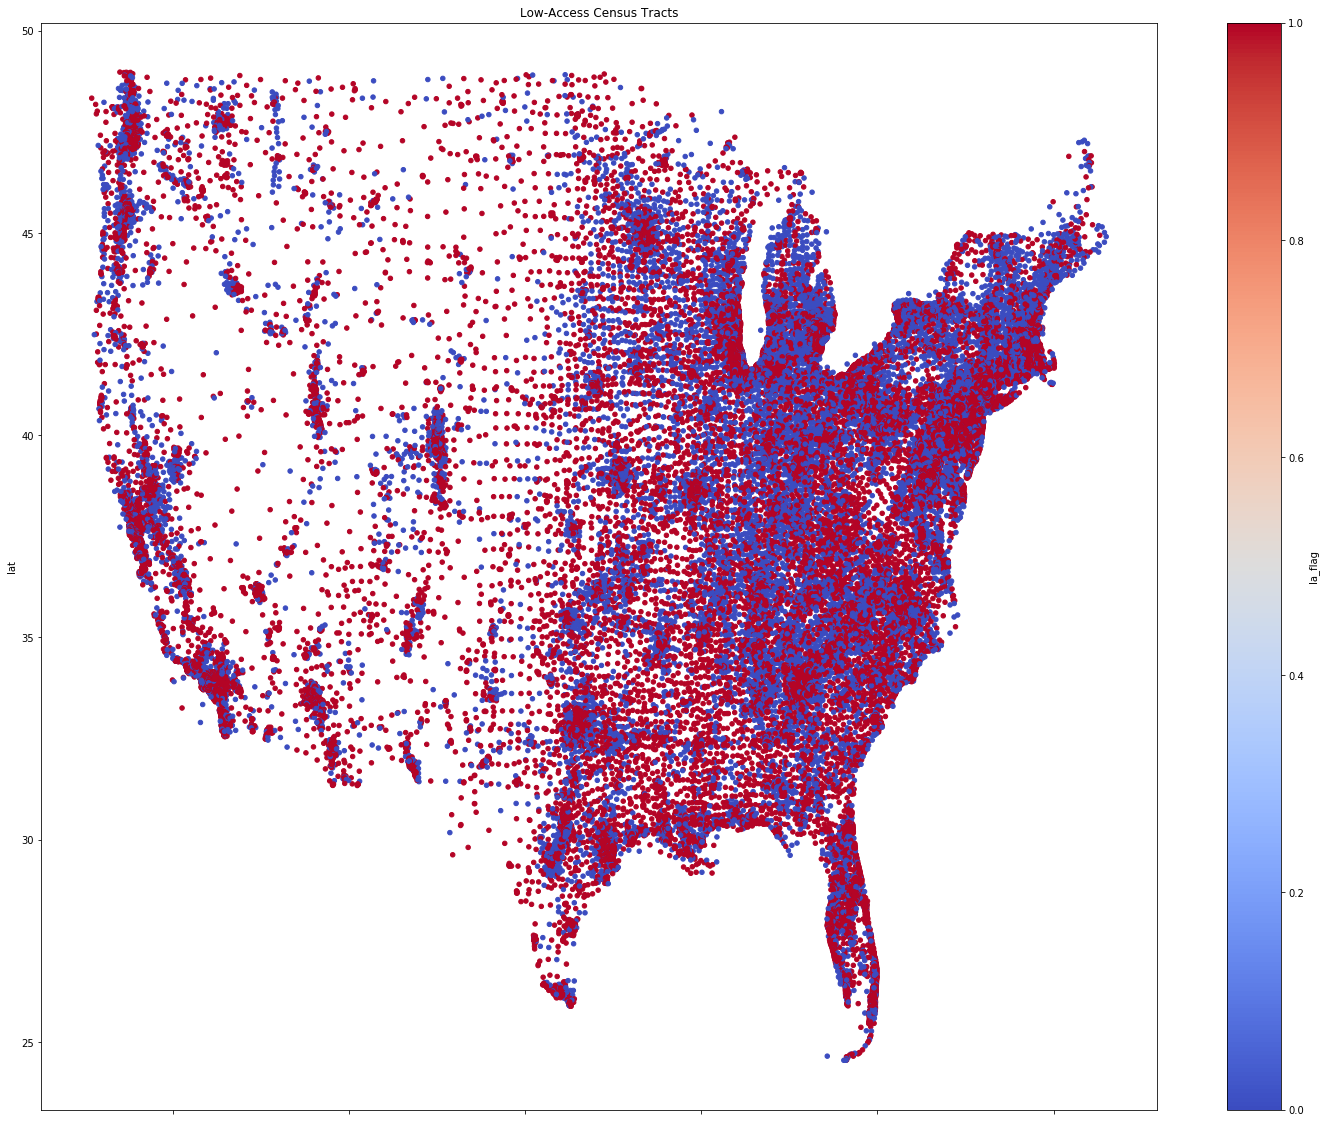

In [234]:
mainland.plot(kind = 'scatter' , x= 'lon', y= 'lat', c = 'la_flag',
              cmap = 'coolwarm',
              title = 'Low-Access Census Tracts',
              figsize = (25,20));

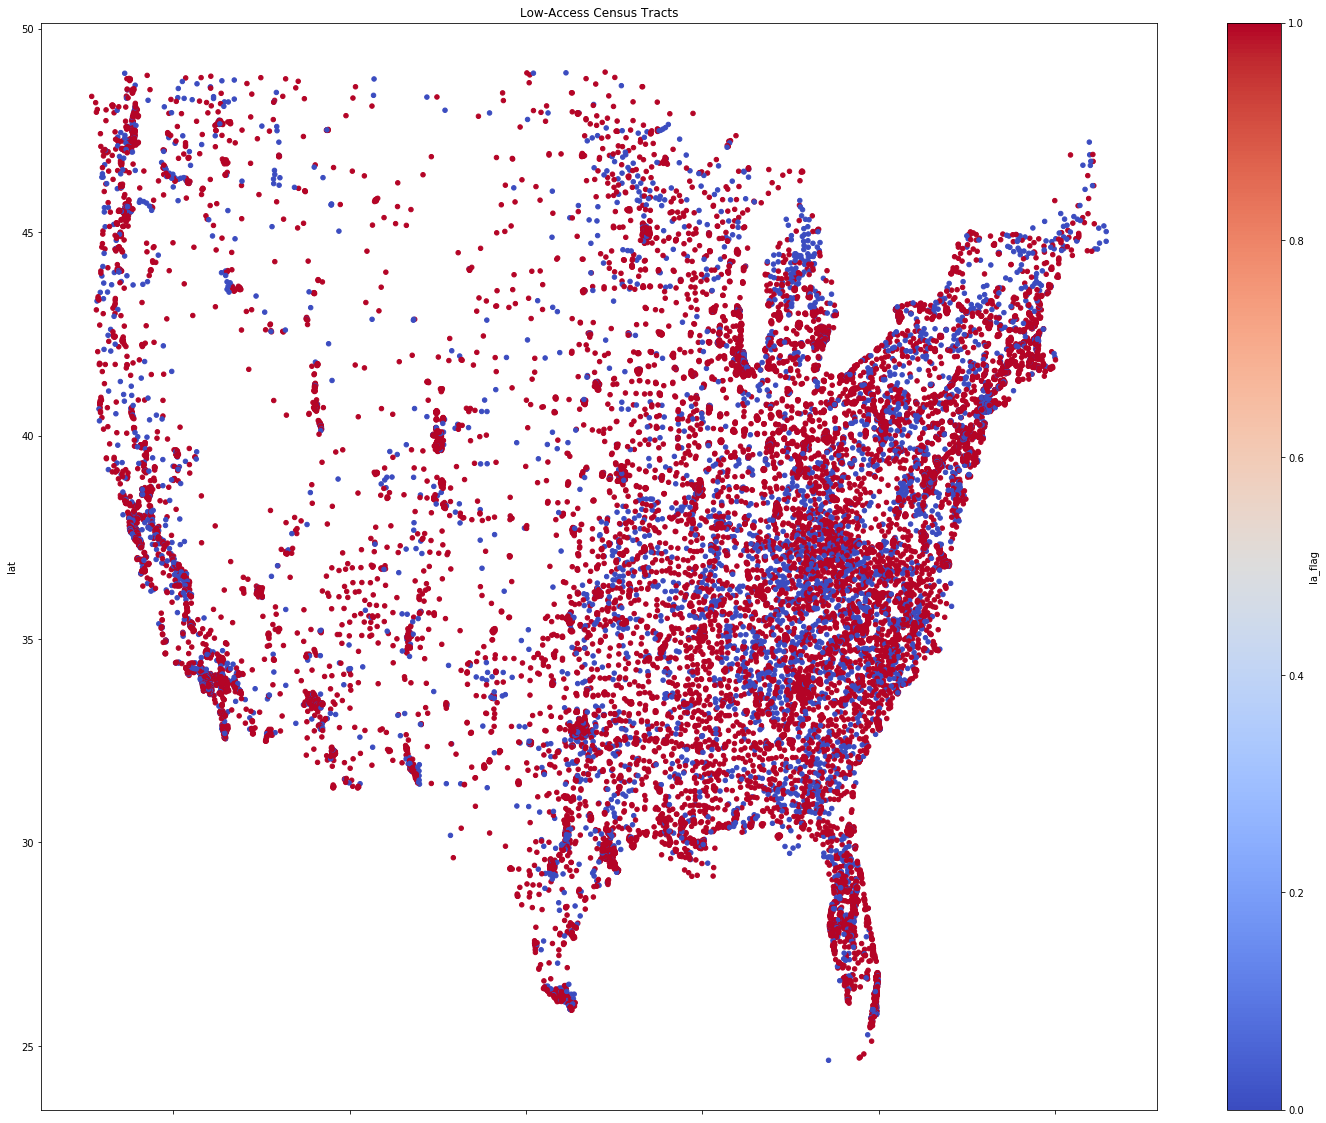

In [236]:
mainland[mainland["LowIncomeTracts"]==1].plot(kind = 'scatter' , x= 'lon', y= 'lat', c = 'la_flag',
              cmap = 'coolwarm',
              title = 'Low-Access Census Tracts',
              figsize = (25,20));

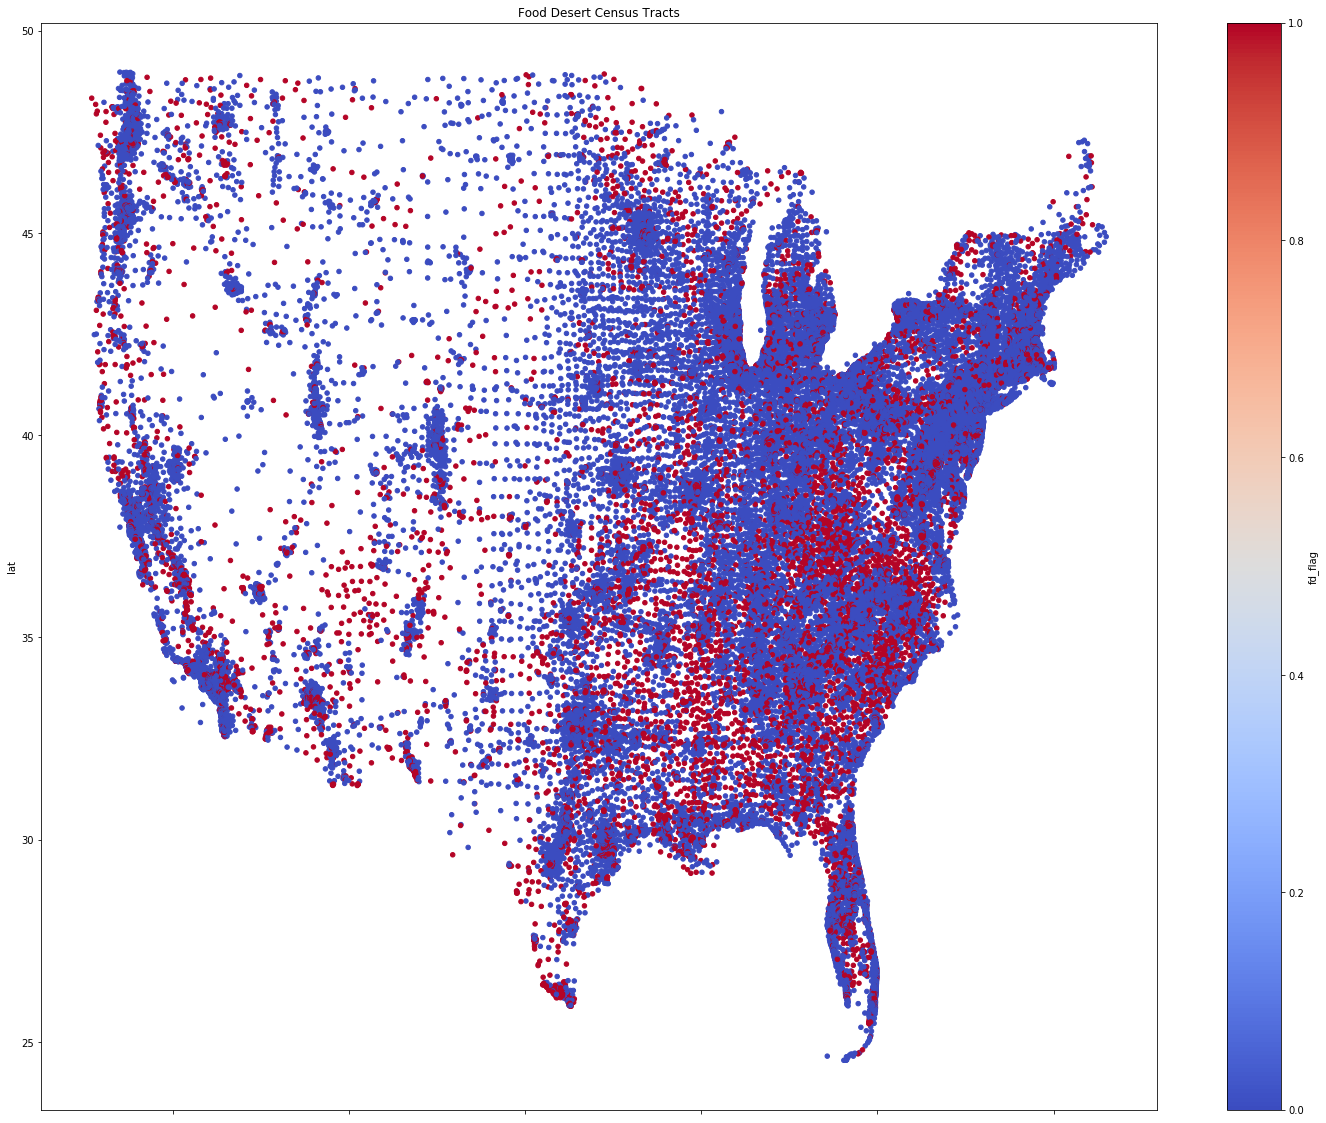

In [11]:
mainland.plot(kind = 'scatter' , x= 'lon', y= 'lat', c = 'fd_flag',
              cmap = 'coolwarm',
              title = 'Food Desert Census Tracts',
              figsize = (25,20));

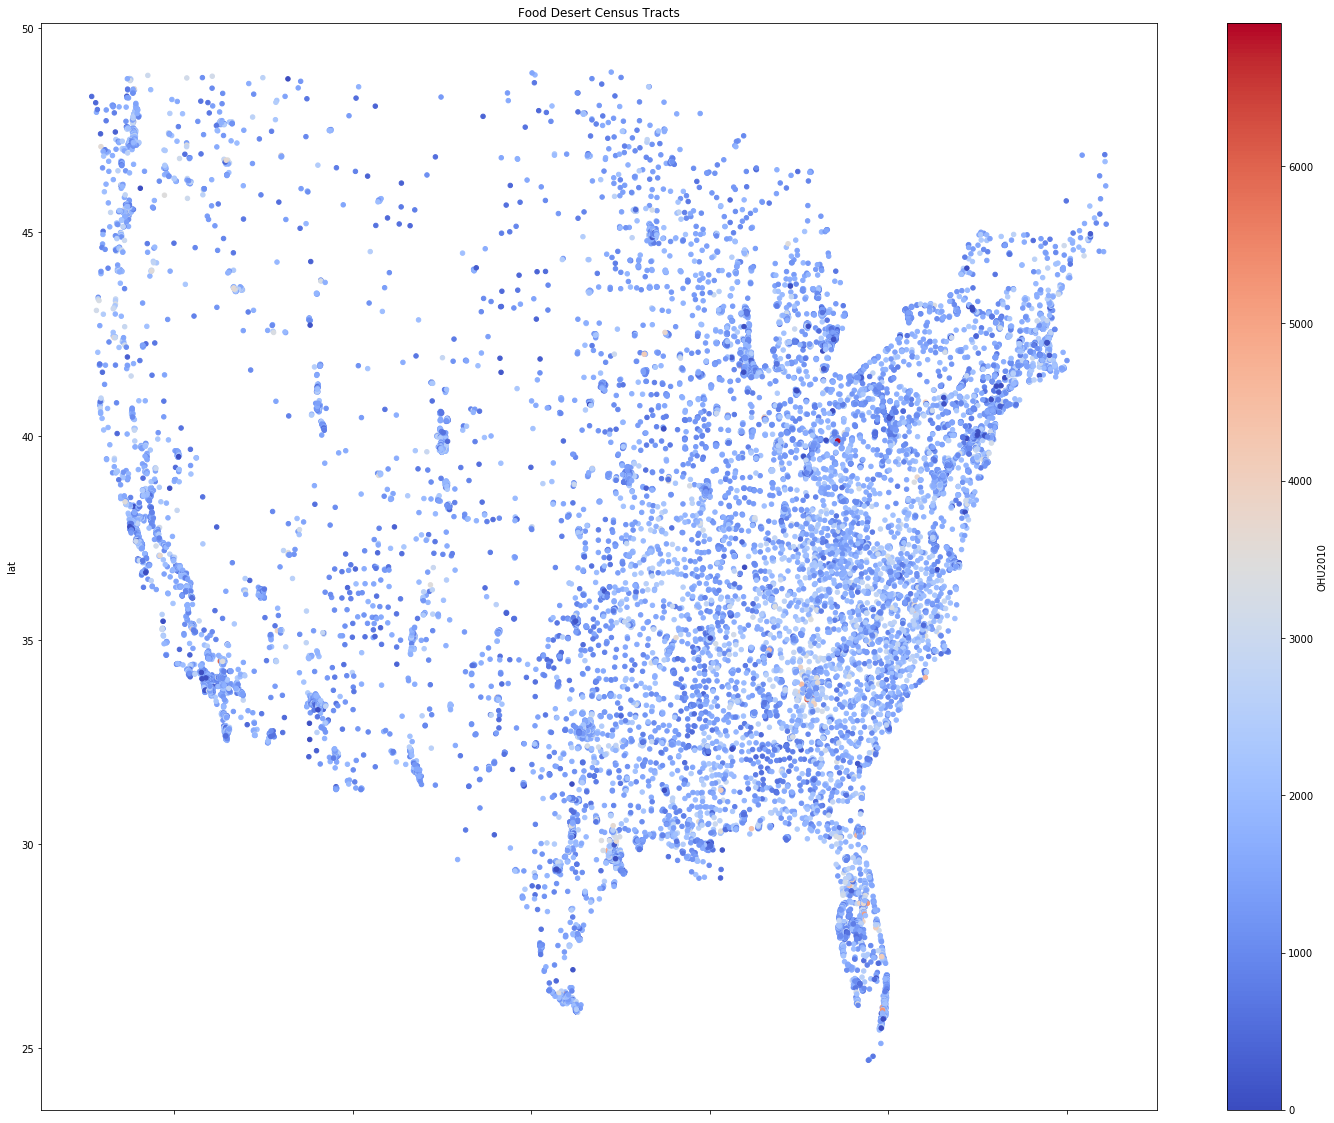

In [244]:
mainland[mainland['fd_flag'] == 1].plot(kind = 'scatter' , x= 'lon', y= 'lat', c = 'OHU2010',
              cmap = 'coolwarm',
              title = 'Food Desert Census Tracts',
              figsize = (25,20));

In [9]:
# Transfer Learning with Clusters
mainland.head()

CensusTract    State   County  Urban  POP2010  OHU2010  GroupQuartersFlag  \
0   1001020100  Alabama  Autauga      1     1912      693                  0   
1   1001020200  Alabama  Autauga      1     2170      743                  0   
2   1001020300  Alabama  Autauga      1     3373     1256                  0   
3   1001020400  Alabama  Autauga      1     4386     1722                  0   
4   1001020500  Alabama  Autauga      1    10766     4082                  0   

   NUMGQTRS  PCTGQTRS  LILATracts_1And10  ...  TractAIAN  TractOMultir  \
0         0  0.000000                  0  ...         14            45   
1       181  0.083410                  0  ...          5            55   
2         0  0.000000                  0  ...         11           117   
3         0  0.000000                  0  ...         11            74   
4       181  0.016812                  0  ...         48           310   

   TractHispanic  TractHUNV  TractSNAP  la_flag  fd_flag       tract  \
0             44         26        112        1        0  1001020100   
1             75         87        202        1        0  1001020200   
2             87        108        120        1        0  1001020300   
3             85         19         82        1        0  1001020400   
4            355        198        488        1        0  1001020500   

         lat        lon  
0  32.477111 -86.490303  
1  32.475758 -86.472468  
2  32.474024 -86.459703  
3  32.471078 -86.444681  
4  32.458916 -86.421817  

[5 rows x 152 columns]

In [129]:
# Clustering our Points geographically
location_data = mainland[['lat', 'lon']]
location_data.head()

lat        lon
0  32.477111 -86.490303
1  32.475758 -86.472468
2  32.474024 -86.459703
3  32.471078 -86.444681
4  32.458916 -86.421817

In [146]:
km = KMeans(n_clusters=20, random_state = 1776)
km.fit(location_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1776, tol=0.0001, verbose=0)

In [171]:
clusters = km.predict(location_data)
mainland.loc[:,'clusters'] = clusters

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


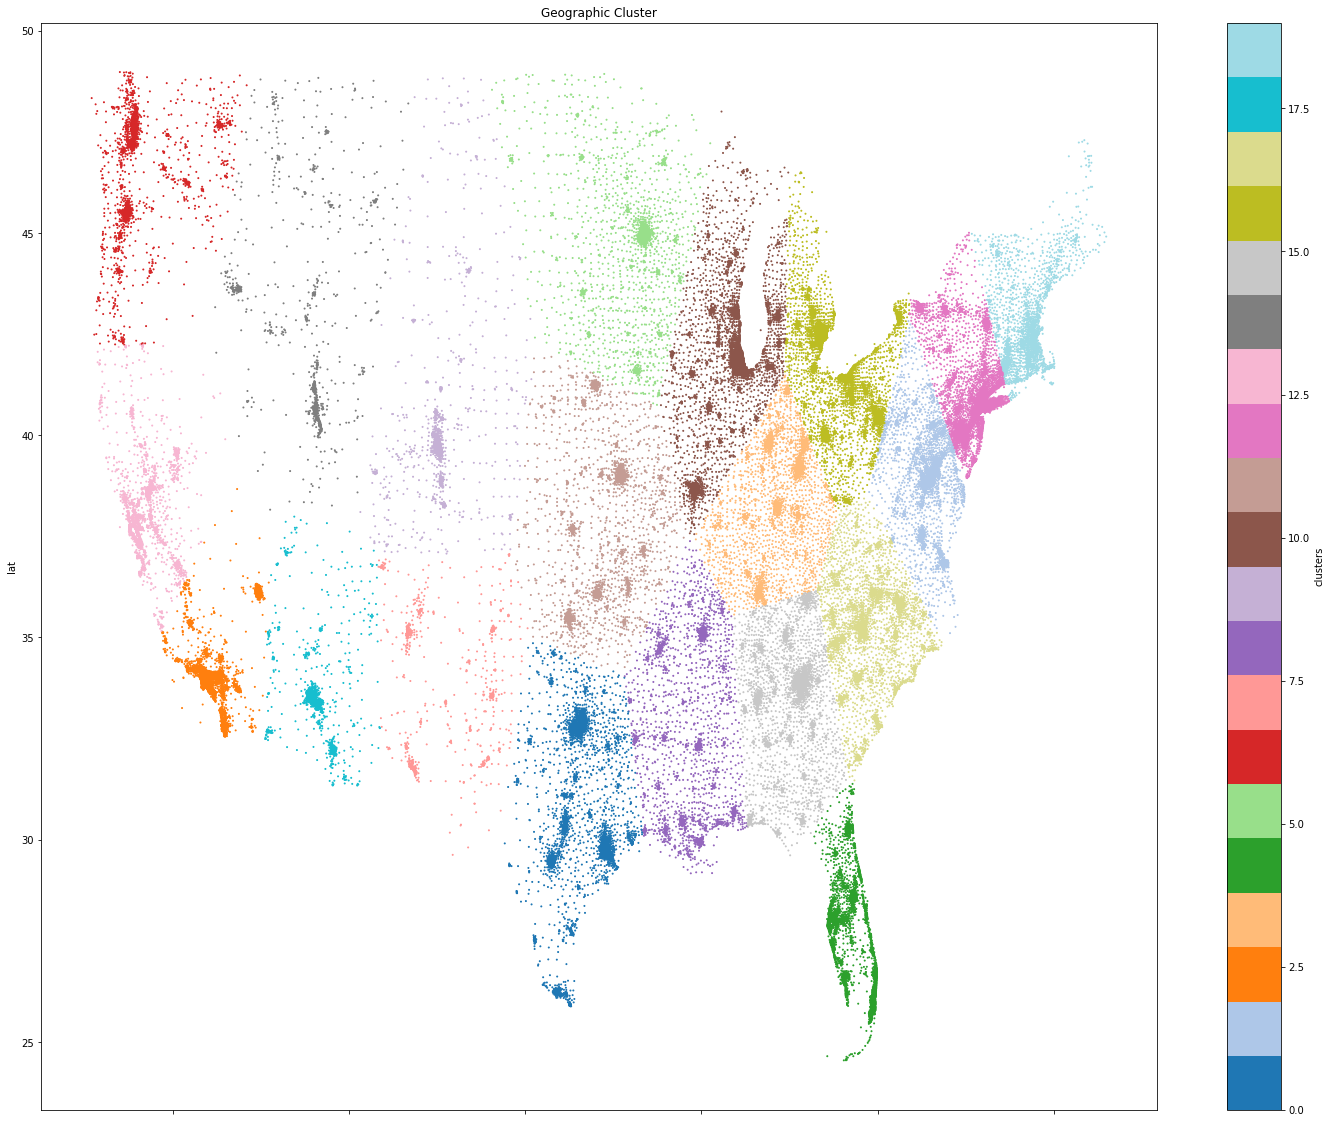

In [223]:
mainland.plot(kind = 'scatter' , x= 'lon', y= 'lat', c = 'clusters',
              cmap = 'tab20',
              title = 'Geographic Cluster',
              s = 1,
              figsize = (25,20));



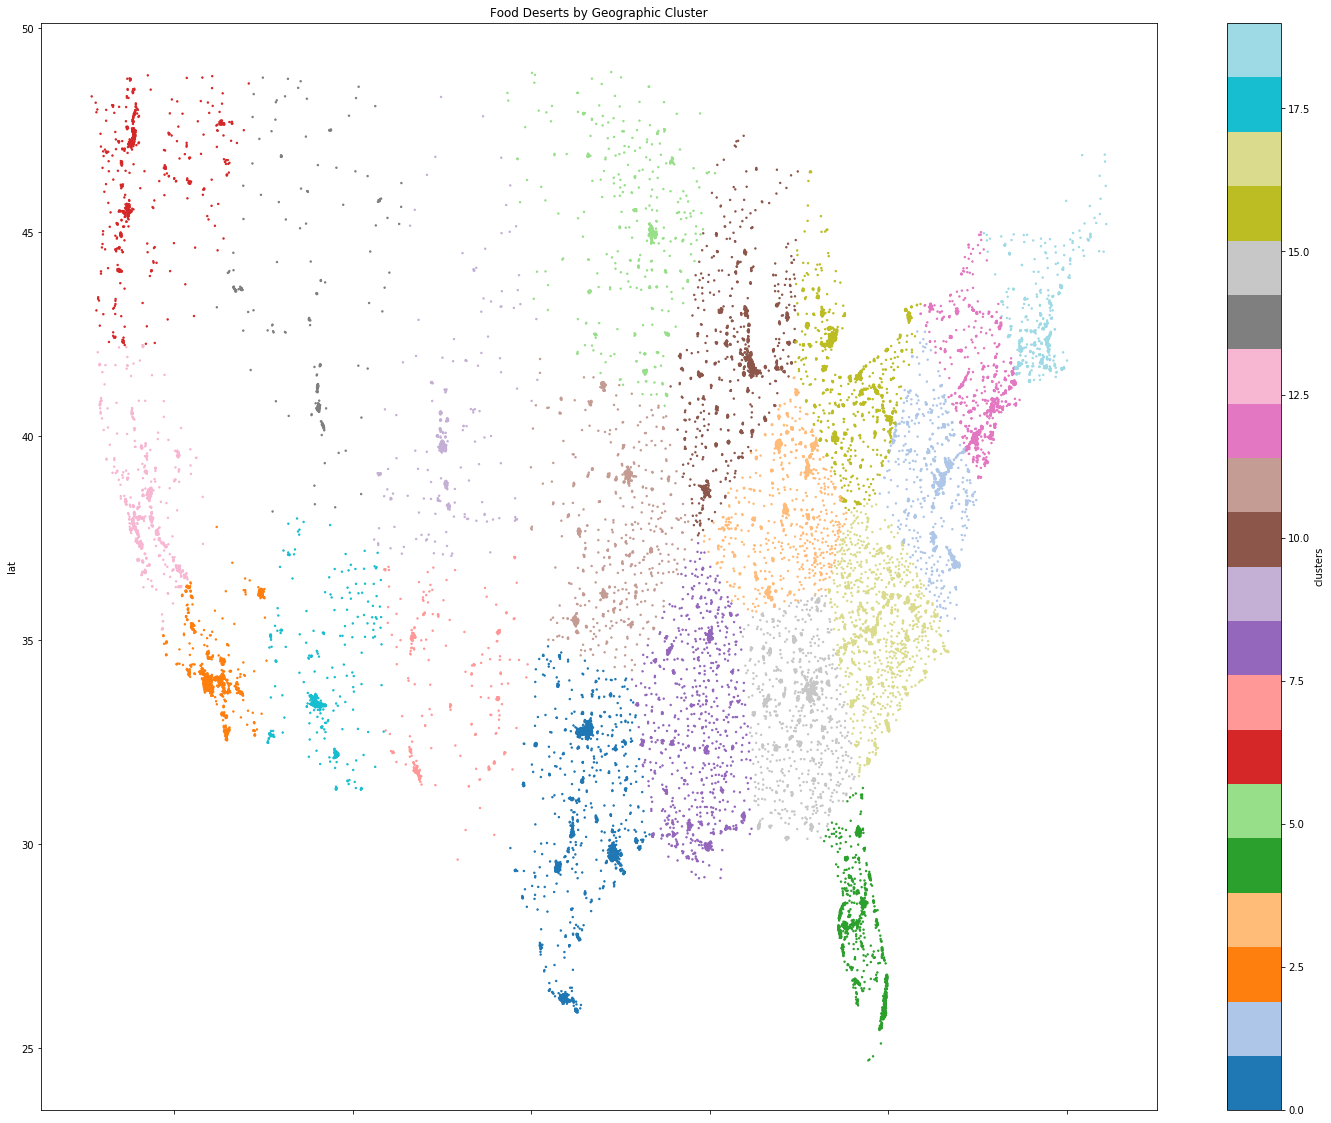

In [229]:
# Map Food Deserts by Cluster
mainland[mainland['fd_flag'] == 1].plot(kind = 'scatter' , x= 'lon', y= 'lat', c = 'clusters',
              cmap = 'tab20',
              title = 'Food Deserts by Geographic Cluster',
              s = 2,
              figsize = (25,20));


In [176]:
# Add these clusters to our data
y = mainland['fd_flag']

# take features from the other two models
features = ['POP2010', 'OHU2010', 'Urban', 'PovertyRate', 'TractHUNV', 'TractSNAP', 'TractLOWI']

X = mainland[features]

X.loc[:, "cluster"] = km.predict(location_data)
X = pd.get_dummies(columns=['cluster'], data = X)
X.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


POP2010  OHU2010  Urban  PovertyRate  TractHUNV  TractSNAP  TractLOWI  \
0     1912      693      1         10.0         26        112        448   
1     2170      743      1         18.2         87        202        763   
2     3373     1256      1         19.1        108        120       1578   
3     4386     1722      1          3.3         19         82       1241   
4    10766     4082      1          8.5        198        488       2692   

   cluster_0  cluster_1  cluster_2  ...  cluster_10  cluster_11  cluster_12  \
0          0          0          0  ...           0           0           0   
1          0          0          0  ...           0           0           0   
2          0          0          0  ...           0           0           0   
3          0          0          0  ...           0           0           0   
4          0          0          0  ...           0           0           0   

   cluster_13  cluster_14  cluster_15  cluster_16  cluster_17  cluster_18  \
0           0           0           1           0           0           0   
1           0           0           1           0           0           0   
2           0           0           1           0           0           0   
3           0           0           1           0           0           0   
4           0           0           1           0           0           0   

   cluster_19  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 27 columns]

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state =42, test_size = 0.5)

In [178]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8366359892767322

In [179]:
# Score on training set. (We'll use R^2 for the score today.)
print(f'Training Score: {round(lr.score(X_train, y_train),4)}.')

# Score on testing set.
print(f'Testing Score: {round(lr.score(X_test, y_test),4)}.')

Training Score: 0.8365.
Testing Score: 0.8366.


In [180]:
#turn it into a data frame
features_df = pd.DataFrame(lr.coef_.T, X_train.columns, columns=['Importance'])
features_df.sort_values('Importance', ascending = False)

Importance
Urban          1.130439
cluster_1      0.394663
cluster_9      0.076973
cluster_13     0.071447
PovertyRate    0.061289
cluster_5      0.026605
TractSNAP      0.003440
TractLOWI      0.001252
OHU2010        0.000549
POP2010       -0.000737
TractHUNV     -0.004003
cluster_0     -0.015078
cluster_18    -0.052353
cluster_8     -0.055708
cluster_19    -0.064274
cluster_11    -0.081786
cluster_7     -0.083634
cluster_14    -0.101468
cluster_17    -0.111722
cluster_6     -0.150679
cluster_3     -0.171463
cluster_15    -0.210243
cluster_10    -0.236857
cluster_16    -0.310823
cluster_4     -0.393212
cluster_2     -0.468389
cluster_12    -0.721098

In [181]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [182]:
print(f'Training score {rfc.score(X_train, y_train)}')
print(f'Testing score {rfc.score(X_test, y_test)}')

Training score 0.9916256702227627
Testing score 0.867230467346544


In [183]:
#turn it into a data frame
features_df = pd.DataFrame(rfc.feature_importances_, X_train.columns, columns=['Importance'])
features_df.sort_values('Importance', ascending = False)



Importance
PovertyRate    0.306567
TractSNAP      0.148839
TractLOWI      0.137815
TractHUNV      0.114885
POP2010        0.090728
OHU2010        0.087728
Urban          0.026358
cluster_12     0.022381
cluster_2      0.005892
cluster_1      0.005290
cluster_10     0.005181
cluster_19     0.004579
cluster_16     0.004069
cluster_0      0.004068
cluster_4      0.003813
cluster_13     0.003533
cluster_17     0.003365
cluster_11     0.003182
cluster_15     0.003014
cluster_3      0.002903
cluster_6      0.002861
cluster_8      0.002792
cluster_5      0.002577
cluster_9      0.002469
cluster_18     0.002364
cluster_14     0.001470
cluster_7      0.001275

In [184]:
# Clusters 1,9 associated with highest Food Desert Flags
# Clusters 12, 2 associated with lowest Food Desert Flags

In [193]:
mainland[(mainland['clusters'] == 1) & (mainland['fd_flag'] == 1)]['State'].value_counts()

Virginia                467
Maryland                407
Pennsylvania            207
District of Columbia     54
North Carolina           40
West Virginia            33
Delaware                 31
New York                  9
Name: State, dtype: int64

In [205]:
cluster = mainland[(mainland['State'] == 'Virginia') | (mainland['State'] == 'Maryland') | (mainland['State'] == 'Pennsylvania') | (mainland['State'] == 'District of Columbia') | (mainland['State'] == 'West Virginia')]

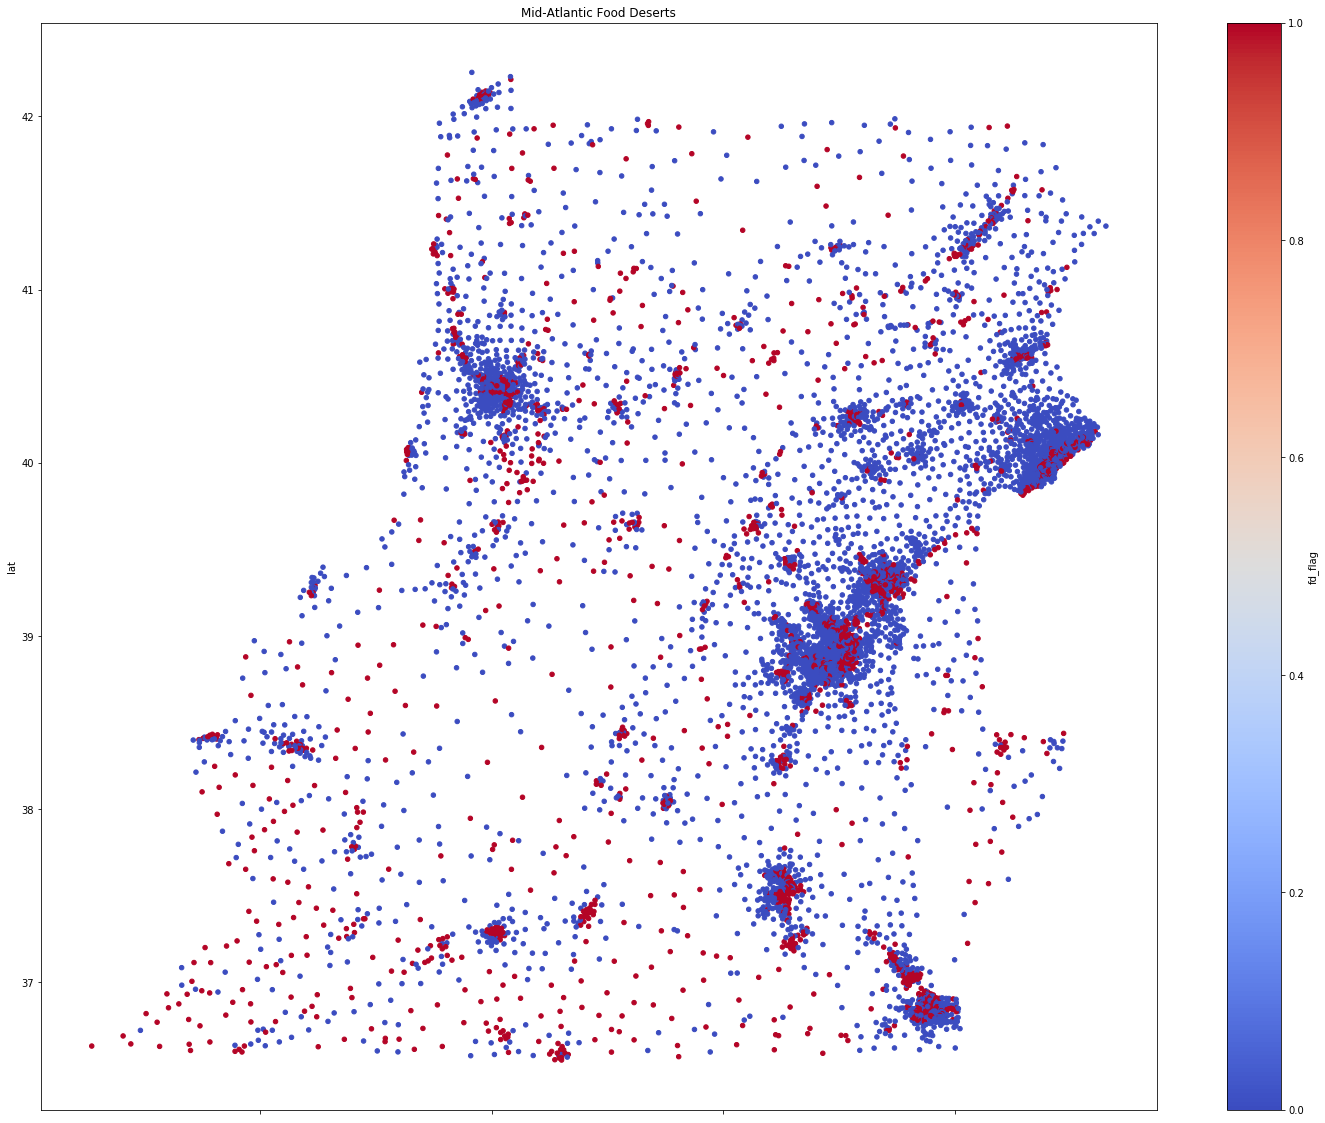

In [207]:
cluster.plot(kind = 'scatter' , x= 'lon', y= 'lat', c = 'fd_flag',
              cmap = 'coolwarm',
              title = 'Mid-Atlantic Food Deserts',
              figsize = (25,20));

In [196]:
mainland[(mainland['clusters'] == 9) & (mainland['fd_flag'] == 1)]['State'].value_counts()

Colorado        423
South Dakota     22
Wyoming          20
Nebraska         12
Kansas            9
Montana           5
North Dakota      3
Name: State, dtype: int64

In [221]:
cluster = mainland[(mainland['State'] == 'Colorado') & (mainland['clusters'] == 9)]

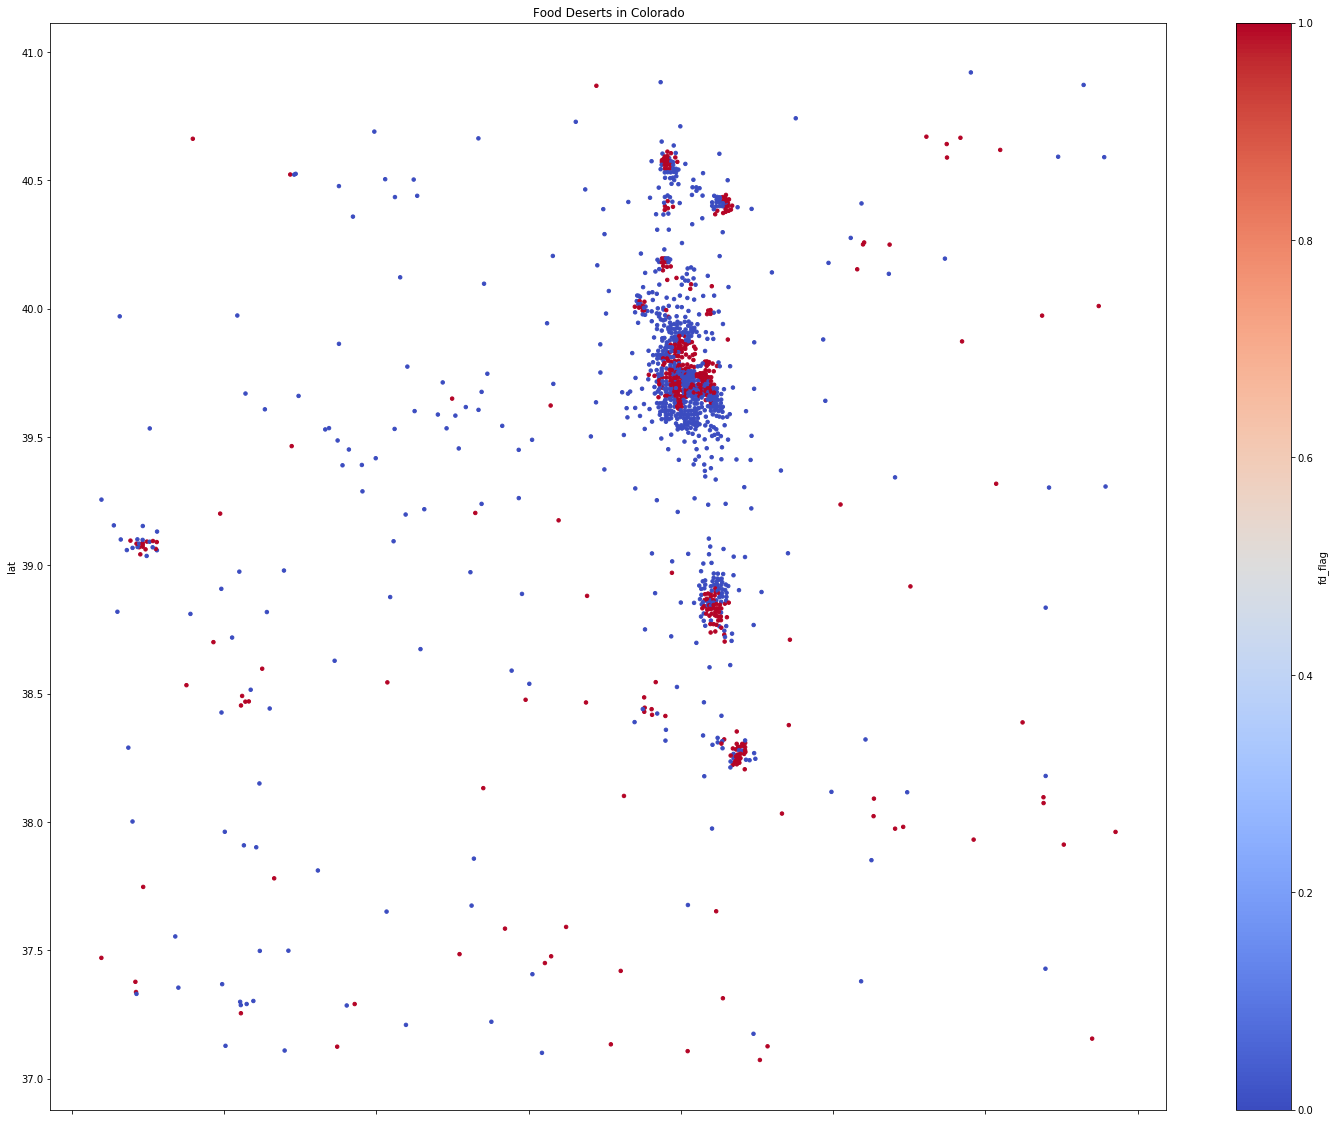

In [222]:
cluster.plot(kind = 'scatter' , x= 'lon', y= 'lat', c = 'fd_flag',
              cmap = 'coolwarm',
              title = 'Food Deserts in Colorado',
             s = 12,
              figsize = (25,20));

In [220]:
mainland[(mainland['clusters'] == 2) & (mainland['fd_flag'] == 1)]['State'].value_counts()

California    1325
Nevada         137
Name: State, dtype: int64

In [ ]:
cluster = mainland[(mainland['State'] == 'California')]

In [188]:
mainland[(mainland['clusters'] == 12) & (mainland['fd_flag'] == 1)]['State'].value_counts()

New York        443
New Jersey      353
Pennsylvania    307
Connecticut     118
Delaware         26
Name: State, dtype: int64